<a href="https://colab.research.google.com/github/riacode/StanfordAI4ALL/blob/main/Complete_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

---
Learning Goals:


*   Implement a logistic regression classifier
*   Compute the accuracy of a model on the test data; compare to accuracy on training data
*   Implement Welch's T-Test to find significant genes
*   Update the logistic regression model including significant genes

AI4ALL Camp Day 7


In [ ]:
#Import some useful things to get started
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression #These are the regression classifiers in the sklearn library
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io
import pandas as pd

#Part 1 -- Initial Logistic Regression

Let's try out regression for our cancer data. Note that our predictor variables are continuous (the gene expression) and the variable we want to predict (the label) is binary. Thus, we should use logistic regression.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving leukemia_ALL_AML.csv to leukemia_ALL_AML.csv


In [ ]:
data = pd.read_csv(io.BytesIO(uploaded['leukemia_ALL_AML.csv']), encoding='utf-8')

Let's start the logistic classifier and train it on the data. First, we will split the data into a training and test set. What do you think is a good size split?

In [ ]:
#First we need to remove the 'label' column from the dataset
#Why do we need to do this?
X = data.drop('label', axis = 1)
y = data.label

# Partition the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0) #here train_size is the proportion of data to put in the training set

#How many entries are in the training data? How many in the test data?
size_test = X_test.shape[0] #FILL IN
size_train = X_train.shape[0] #FILL IN
print(size_train, size_test)


36 36


Now let's initiate the classifier and train it on the training data. Here we're using the LogisticRegression class built in to our favorite library sklearn.

In [ ]:
# Instantiate the classifier
# The parameters here are the default values for LogisticRegression,
# don't worry about them
log_clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter = 100)

# Train the classifier
log_clf.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Remember that logistic regression is fitting a function to the data that outputs a probability (a number between 0 and 1). Let's look and see what these predicted values are for the training data.  Print out the probabilities -- what do you notice about the values?

In [ ]:
train_probs = log_clf.predict_proba(X_train)[:,1]


Now let's classify the test data using the numbers. That is, we want to label everything with predicted probability > threshold as 1, and everything else as 0.

In [ ]:
threshold = 0.5

test_probs = log_clf.predict_proba(X_test)[:,1] #the predicted probabiilities for the test data

predicted_labels = [] #This will contain 0s and 1s

#One way of doing this is a loop, but feel free to use whatever method you like!
for p in test_probs:
  #Convert the value p (a number between 0 and 1) to either 0 or 1
  if p > threshold:
    predicted_labels.append(1)
  else:
    predicted_labels.append(0)

# a fancier way
# predicted_labels = (test_probs > threshold).astype(int)


The classifier can also give you the labels directly! (Using default threshold = 0.5) Print these out and compare to your result.

In [ ]:
test_preds = log_clf.predict(X_test)

We can do a quick plot to visualize how many the logistic regression correctly predicted. We can just plot the true value minus the prediction -- so if it's equal to 0, then the prediction was correct. If it's equal to 1 or -1 then the prediction was incorrect.

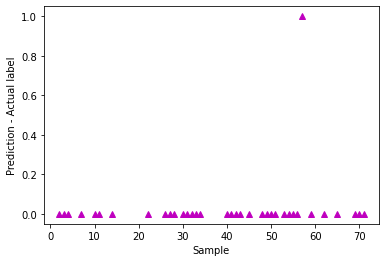

In [ ]:

# Plot the logistic regression predictions
# 'm^' means magenta is the color, triangle is the shape
plt.plot(y_test - test_preds, 'm^')

# Label axes and legend
plt.xlabel("Sample")
plt.ylabel("Prediction - Actual label")
#plt.legend(('Predicted - Actual'), loc="lower right", fontsize='small')
# Show the plot
plt.show()



Can you see how many we got inccorect? Let's calculate the percent accuracy (the proportion correctly predicted) for the logistic regression. Fill in the below function.



In [ ]:
#Let's make a general function
def accuracy(predicted, actual):
    '''
    predicted: array of the predicted values (0 or 1)
    actual: array of the real values (0 or 1)
    '''
    #FILL IN
    actual = np.array(actual)
    predicted = np.array(predicted)
    num_correct = 0
    num_total = predicted.shape[0]
    for i in range(num_total):
      if predicted[i] == actual[i]:
        num_correct += 1

    # a fancier way
    # num_correct = (actual == predicted).sum()

    accuracy = num_correct / num_total

    return accuracy



Calculate the accuracy on both the test set and the training set. What do you think it will be for the training test?

In [ ]:

#Accuracy for the test set
print(accuracy(test_preds, y_test))

train_preds = log_clf.predict(X_train)
#Accuracy for the training set
print(accuracy(train_preds, y_train))



0.9722222222222222
1.0


We can also use the built-in function "score". Use it to check your accuracy function.

In [ ]:
log_clf.score(X_test, y_test)

0.9722222222222222

Compare with classmate's result. Do you get the same numbers?

Things to explore on your own if you want:

1. Change the split size of training/test and see what happens
2. See how accuracy changes with different threshold values -- But only see how the accuracy on the *training* data is changed. Remember that we want to keep the test data separate until we've finalized our model. If we use the test data to change our model, that's cheating!
3. Compute false positive/false negatives and make the confusion matrix (we'll do this more in future days).

#Part 2 -- Gene Selection

The more genes we include in the model, the better the results will be on the training set. However, we don't want to over-fit. We saw that the model's accuracy on the training set was close to 1.0 -- what does this mean?

So, how do we decrease the number of features and decide what genes to include? One way is to do a hypothesis test on each gene to determine if there is a statistically significant difference between the two groups. Then, only include the genes for which there is a significant difference.

###Welch's T-Test

Remember the formula for the t-statistic: We have two groups of data. $X_1, X_2$.
* $\overline{x_1}$ is the mean of the first group, $\overline{x_2}$ is the mean of the second group
* $s_1$ and $s_2$ are the standard deviations of each group
* $n_1$ is the number of points in group $X_1$, $n_2$ is the number of points in group $X_2$

The t-statistic is
$$
t = \frac{\overline{x_1} -  \overline{x_2}}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$

We also need the degree of freedom. The formula is
$$
df = \frac{\left( \frac{s_1^2}{n_1} + \frac{s_2^2}{n_2} \right)^2}{\frac{s_1^4}{n_1^2 \cdot (n_1 - 1)} + \frac{s_2^4}{n_2^2 \cdot (n_2 - 1)}}
$$

(REMARK: Try to write the formula for coding practice, but there is always a built-in function you can use.)

In [ ]:
def welch_test(X1, X2):
    '''
    X1: array of data points
    X2: array of data points
    NOTE X and Y do not have to be the same length
    '''
    #-------------First, let's calculate all of the variables you'll need:

    #the mean of each group
    m1 = np.mean(X1)
    m2 = np.mean(X2)

    #The standard deviations of each group
    s1 = np.std(X1)
    s2 = np.std(X2)

    #The number of samples in in each group
    n1 = X1.shape[0]
    n2 = X2.shape[0]

    #-------------Now, calculate the t-statistic
    #Calculate the numerator and denominator
    t_num = m1 - m2
    t_denom = (s1**2/n1 + s2**2/n2)**0.5

    t_stat = t_num/t_denom

    #-------------Finally, calculate the degree of freedom
    df_num = (s1**2/n1 + s2**2/n2)**2
    df_denom = s1**4/(n1**3-n1**2) + s2**4/(n2**3-n2**2)

    df = df_num/df_denom

    #Return both values
    return([t_stat, df])



Now let's loop through the genes and do the t-test comparing the groups. From the t-statistic and the degree of freedom, we can use a built-in function to get the p-value.  

NOTE: If you're short on time, or frustrated with all the algebra, you can use the ttest function from scipy.stats. This will give you the p-value directly:      

```
p_value = ttest_ind(X, Y, equal_var = False)[1]
```
This is included as a commented line in the code below.


In [ ]:
from scipy.special import stdtr
from scipy.stats import ttest_ind


# First let's get the number of genes we have to loop through
number_of_genes = data.shape[1] - 1 #FILL IN

selected_genes = [] #This list will store the genes we decide are significant

for gene_id in range(number_of_genes):

    expressions = data.iloc[:, gene_id]

    #Get all oft the label0 values for this gene, and all the label1 values
    label0 = expressions[data.label == 0]
    label1 = expressions[data.label == 1]

    result = welch_test(label0, label1)
    t_stat = result[0]
    df = result[1]

    # now we can use an existing funtion to find the p-value (don't worry about this!)
    # it is same as looking-up the t-test table!
    p_value = 2*stdtr(df, -np.abs(t_stat))

    #Un-comment this line if you want to use the built-in function
    # p_value = ttest_ind(label0, label1, equal_var = False)[1]

    #FILL IN -- write an if-statement to check if the p_value is less than 0.05. If so, add it to our selected_genes list
    #Recall that to add to a list, you can do ".append(item)"
    if p_value < 0.05:
      selected_genes.append(gene_id)


#Print out the number of genes we selected
print ('Number of informative genes: ', len(selected_genes)) #FILL IN, add the length of selected_genes list



Number of informative genes:  1762


Now, let's update the model to only include the genes which are informative, and see how it improves the accuracy.


In [ ]:
#This creates a data frame with only our selected genes
X_filt = X.iloc[:, selected_genes]
y_filt = y #Still the same y


# Partition the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_filt, y_filt, train_size=0.5, random_state=0)

# Instantiate the classifiers
# The parameters here are the default values for LogisticRegression,
# included here just to suppress a couple warnings
log_clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter = 100)

# Train the classifiers
log_clf.fit(X_train, y_train)

# Calculate predictions on test set
log_predictions = log_clf.predict(X_test)

print(log_clf.score(X_train, y_train))
print(log_clf.score(X_test, y_test))


1.0
0.9722222222222222


Compare your accuracy to a classmates. If you get different numbers, why? Are you surprised at how well our classifier does? What do you think will happen if we get a larger data set?

DISCUSSION: